# Megaline: Smart or Ultra

The mobile company Megaline is not satisfied seeing many of its customers using legacy plans. They want to develop a model that can analyze customer behavior and recommend one of Megaline's new plans: Smart or Ultra.

You have access to behavioral data from subscribers who have already switched to the new plans (from the Data Statistical Analysis course project). For this classification task, you should create a model that chooses the right plan. Since you have already gone through the data processing step, you can jump straight into creating the model.

Develop a model with the highest accuracy possible. In this project, the accuracy threshold is 0.75. Use the dataset to check the accuracy.

# Data Description

Each observation in the dataset contains monthly behavior information about a user. The provided information is as follows:

- `сalls` — number of calls.
- `minutes` — total call duration in minutes.
- `messages` — number of text messages.
- `mb_used` — Internet traffic used in MB.
- `is_ultra` — plan for the current month (Ultra - 1, Smart - 0).


# Initialization

In [55]:
# Load libraries

# Data manipulation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV

# Evaluation
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Load data

In [56]:
# Load the data into DataFrames
df = pd.read_csv('../datasets/users_behavior.csv')

In [57]:
# Print the general/summary information about the DataFrames
df.info()

# Print a random sample of 5 rows from the DataFrame
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
712,68.0,458.15,137.0,10933.27,1
1205,65.0,444.02,77.0,9753.24,0
3077,22.0,120.09,16.0,9039.57,0
2959,23.0,135.99,23.0,19867.72,0
767,26.0,193.78,14.0,13946.36,0


## Observations
- All columns have the correct data types and have no missing values (just as mentioned in the project description).

# EDA

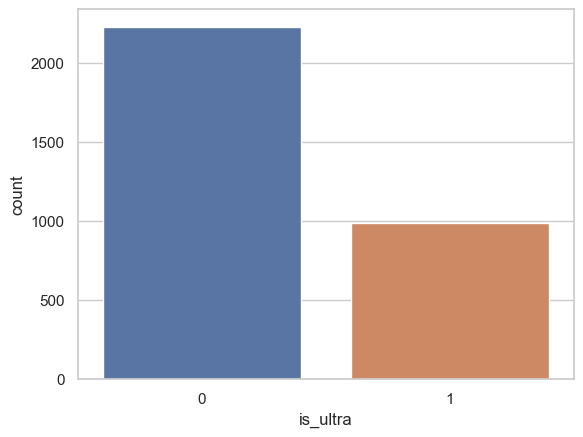

In [58]:
# Create a graph to visualize the distribution of the target variable
sns.countplot(x='is_ultra', data=df)
plt.show()

## Observations
- Eventhough we have a preprocessed dataset, there is an imbalance of classes for the target variable.

## Oversampling

In [59]:
# Set random seed for reproducibility
random_state = 12345

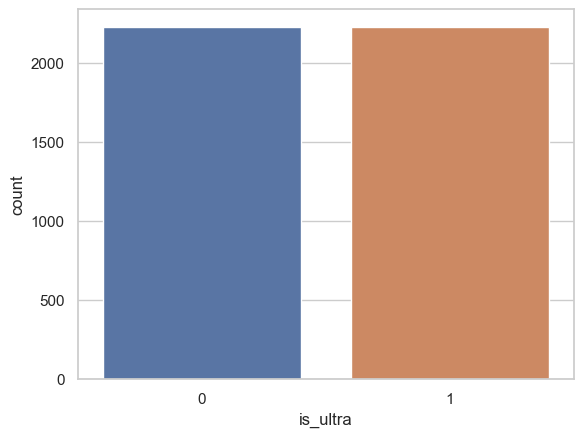

In [60]:
# Adjust the class imbalance by oversampling the minority class
df_majority = df[df['is_ultra'] == 0]
df_minority = df[df['is_ultra'] == 1]
df_minority_upsampled = df_minority.sample(df_majority.shape[0], replace=True,  random_state=random_state)
df = pd.concat([df_majority, df_minority_upsampled]).sample(frac=1, random_state=random_state).reset_index(drop=True)

# Create a graph to visualize the distribution of the target variable
sns.countplot(x='is_ultra', data=df)
plt.show()

In [61]:
# Print the general/summary information about the DataFrames
df.info()

# Print a random sample of 5 rows from the DataFrame
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4458 entries, 0 to 4457
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     4458 non-null   float64
 1   minutes   4458 non-null   float64
 2   messages  4458 non-null   float64
 3   mb_used   4458 non-null   float64
 4   is_ultra  4458 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 174.3 KB


,calls,minutes,messages,mb_used,is_ultra
213,78.0,491.15,26.0,7497.19,1
3915,69.0,442.96,99.0,26423.48,0
2609,83.0,590.47,103.0,27851.01,0
652,84.0,572.48,5.0,28775.89,1
1809,37.0,292.84,18.0,4080.59,0


# Model construction

## Data Segmentation

In [62]:
# Separate the data into features and target
features = df.drop("is_ultra", axis=1)
target = df["is_ultra"]

In [63]:
# Divide the data into training, validation, and test subsets (3:1:1)
features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, target, test_size=.4, random_state=random_state)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test, target_valid_test, test_size=.5, random_state=random_state)

## Find the best hyperparameters

In [64]:
# Set the scoring metric to be used for choosing the best hyperparameters
scoring = 'roc_auc'

In [65]:
# Create a function to calculate the best hyperparameters for a list of models
def find_best_params(models, features_train, target_train, scoring):
    # Create a DataFrame to store the results
    results = pd.DataFrame(columns=['Model', 'Best Parameters', 'Best Score'])

    # Iterate through the list of models
    for model in models:
        # Print the name of the model
        print(f"Finding best parameters for {type(model['model']).__name__}...")

        # Perform a grid search of the hyperparameters
        grid = GridSearchCV(model['model'], model['param_grid'], cv=5, scoring=scoring, verbose=0, n_jobs=-1)
        grid.fit(features_train, target_train)

        # Extract best parameters and score
        best_params = grid.best_params_
        best_score = np.abs(grid.best_score_)

        # Store the results in the DataFrame
        results = pd.concat([results, pd.DataFrame({'Model': type(model['model']).__name__, 
                                  'Best Parameters': [best_params], 
                                  'Best Score': best_score})], ignore_index=True)

        # Sort the DataFrame by best score
        results.sort_values(by='Best Score', ascending=False, inplace=True)

    # Create a bar plot to visualize the best scores
    plt.figure(figsize=(12, 10))
    sns.barplot(data=results, x='Model', y='Best Score', palette="coolwarm")
    plt.title("Grid Search Results (higher score is better)")
    plt.xticks(rotation=45)
    plt.tight_layout()

    return results

Finding best parameters for LogisticRegression...
Finding best parameters for RandomForestClassifier...
Finding best parameters for DecisionTreeClassifier...


,Model,Best Parameters,Best Score
0,RandomForestClassifier,"{'max_depth': 14, 'n_estimators': 90}",0.902429
2,DecisionTreeClassifier,{'max_depth': 14},0.814855
1,LogisticRegression,{},0.581170


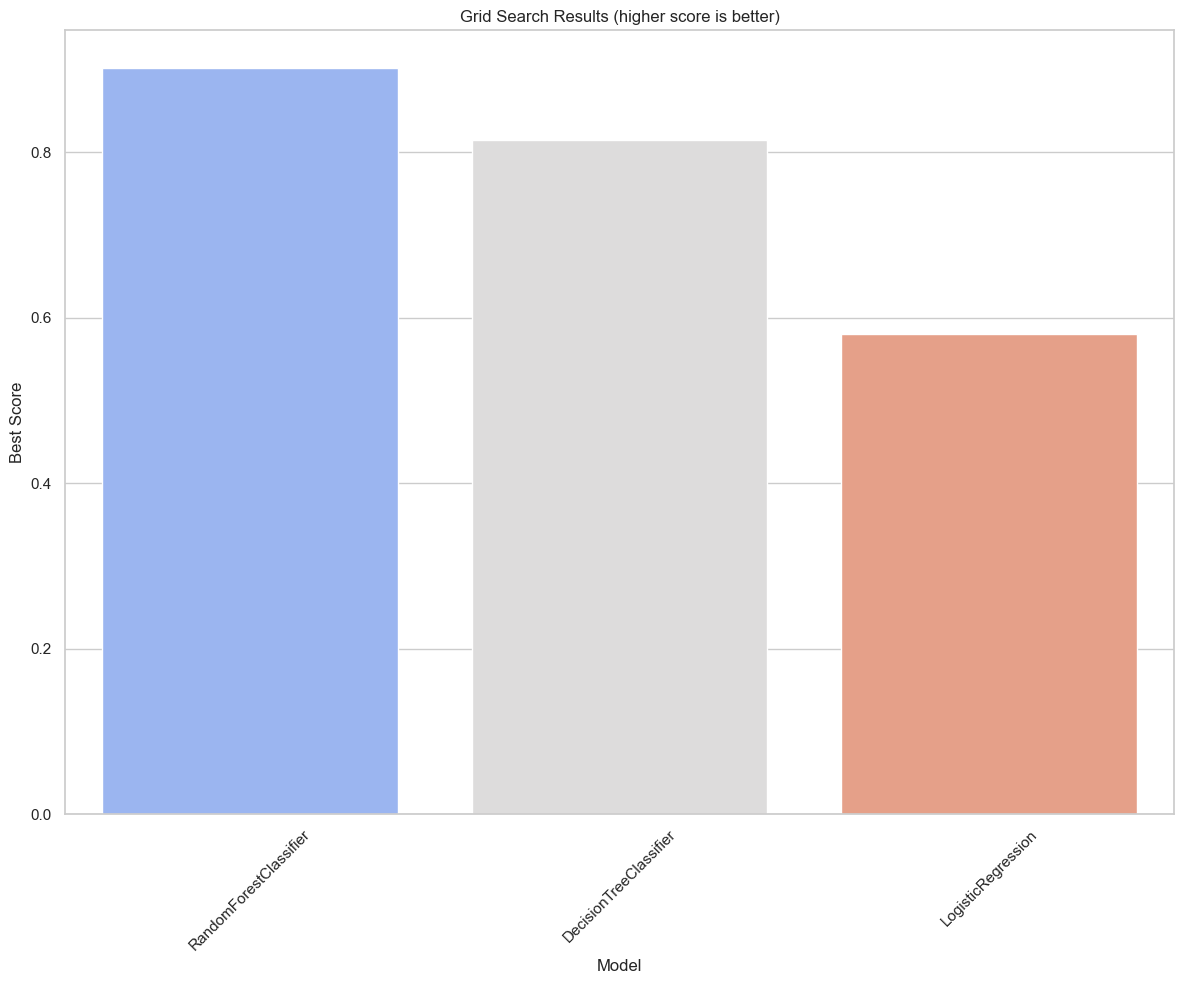

In [66]:
# Define the models and their basic hyperparameters
models = [
    {
        'model': LogisticRegression(random_state=random_state),
        'param_grid': {}
    },
    {
        'model': RandomForestClassifier(random_state=random_state),
        'param_grid': {'n_estimators': np.arange(10, 100, 10), 'max_depth': np.arange(3, 15)}
    },
    {
        'model': DecisionTreeClassifier(random_state=random_state),
        'param_grid': {'max_depth': np.arange(3, 15)}
    },
]

# Find the best hyperparameters for each model
results = find_best_params(models, features_train, target_train, scoring)

# Print the results
results

In [67]:
# Set the index of the DataFrame to the model name
results.set_index('Model', inplace=True)

# Set the hyperparameters for each model based on the results of the grid search
models = [
    LogisticRegression(random_state=random_state, **results.loc['LogisticRegression']['Best Parameters']),
    RandomForestClassifier(random_state=random_state, **results.loc['RandomForestClassifier']['Best Parameters']),
    DecisionTreeClassifier(random_state=random_state, **results.loc['DecisionTreeClassifier']['Best Parameters']),
]

## Train and evaluate models

In [68]:
# Create a function to train and evaluate multiple models on the training and validation subsets and create a graph to visualize the results
def train_and_evaluate_models(models, features_train, target_train, features_valid, target_valid):
    # Create a DataFrame to store the results
    results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC'])
    
    # Loop through each model
    for model in models:
        # Train the model
        model.fit(features_train, target_train)
        
        # Make predictions
        predictions = model.predict(features_valid)
        
        # Evaluate the model
        accuracy = model.score(features_valid, target_valid)
        precision = precision_score(target_valid, predictions)
        recall = recall_score(target_valid, predictions)
        f1 = f1_score(target_valid, predictions)
        roc_auc = roc_auc_score(target_valid, predictions)
        
        # Append the results to the DataFrame
        results = pd.concat([results, pd.DataFrame({'Model': model.__class__.__name__, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1, 'ROC_AUC': roc_auc}, index=[0])], ignore_index=True)
    
    # Draw a heatmap to visualize the results
    plt.figure(figsize=(14,7))
    sns.set(style="whitegrid")
    sns.heatmap(results.set_index('Model'), annot=True, cmap='RdBu_r')
    plt.title('Model Comparison')
    plt.ylabel('Model')
    plt.tight_layout()
    plt.show()

    return results

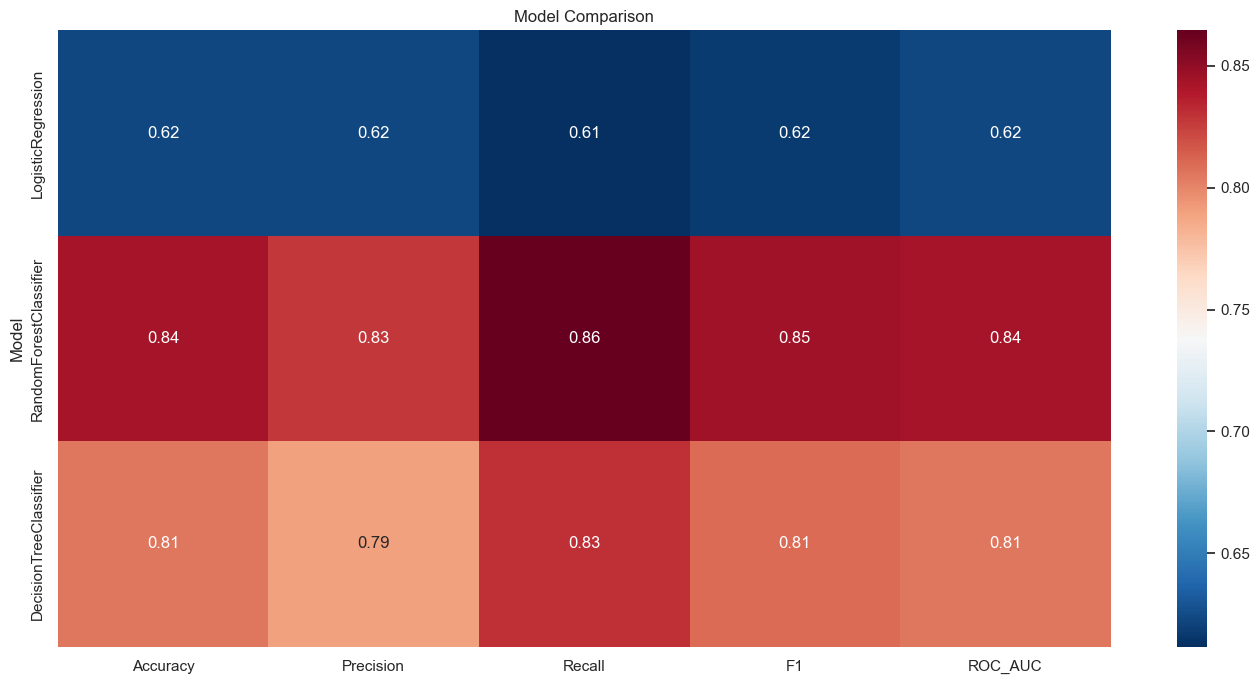

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,LogisticRegression,0.623318,0.622989,0.611738,0.617312,0.623241
1,RandomForestClassifier,0.843049,0.827214,0.864560,0.845475,0.843193
2,DecisionTreeClassifier,0.806054,0.789700,0.830700,0.809681,0.806218


In [69]:
# Train and evaluate the models
train_results = train_and_evaluate_models(models, features_train, target_train, features_test, target_test)

# Print the results
train_results

## Intermediate Conclusion

- The `Random Forest` Classifier demonstrated the highest performance across all evaluated metrics, including Accuracy, Precision, Recall, F1, and ROC_AUC, indicating it has the strongest predictive power among the models tested.

- The `Logistic Regression` model showed the lowest scores in terms of the same metrics, suggesting it has the least predictive power for this particular dataset.

- The `Decision Tree` Classifier achieved scores that were lower than the Random Forest but higher than Logistic Regression. It was the second-best in terms of Accuracy, F1, and ROC_AUC, and offered a good balance between Precision and Recall.

The **`Random Forest`** model with the hyperparameters `'max_depth': 14, 'n_estimators': 90` will be the chosen model as it has the best balance across all metrics.

# Model Quality Assessment

In [70]:
# Train a decision tree model with the maximum depth found earlier and determine the accuracy on the validation set
model = RandomForestClassifier(random_state=random_state, max_depth=14, n_estimators=90)
model.fit(features_train, target_train)
score_val = model.score(features_valid, target_valid)

print("Accuracy of the decision tree model on the validation set:", score_val)

Accuracy of the decision tree model on the validation set: 0.8307174887892377


## Sanity Check

In [71]:
# Create a dummy classifier that always predicts the most frequent class
dummy = DummyClassifier(strategy='most_frequent', random_state=random_state)
dummy.fit(features_train, target_train)

# Calculate the score on the test data
dummy_score = dummy.score(features_test, target_test)

print(f'Dummy Classifier Score: {dummy_score}')

Dummy Classifier Score: 0.4966367713004484


## Intermediate Conclusion

- The `Dummy` Classifier, which always predicts the most frequent class, guesses correctly around 50% of the time.
- The `Random Forest` Classifier guesses correctly 84.3% of the time. This indicates that the model is learning from the data and making predictions that are significantly better than a model that just guesses the most frequent class.

# General Conclusion

The tested classification models included the `Decision Tree`, `Random Forest`, and `Logistic Regression`. The analysis revealed that:

- The `Random Forest` model scored the highest across all metrics, which often comes at the cost of increased computational complexity and execution time.
- The `Decision Tree` model scored in the middle range for most metrics and offered the second shortest execution time.
- The `Logistic Regression` model had the lowest scores, but it benefitted from the shortest execution time.

The `Random Forest` model with the hyperparameters `'max_depth': 14, 'n_estimators': 90` was chosen for its high metrics scores. This model outperformed the `Dummy Classifier`, indicating that the model is learning from the data and making predictions that are significantly better than a model that merely guesses the most frequent class.